# MVP Sprint 2 - Parte 1: - Modelo de classificação: Dataset Bank Customer Churn : Dados de clientes bancários para Churn de clientes

Conjunto de dados: Kaggle


Trabalho realizado durante a segunda Sprint do Curso de Pós Graduação em Ciência de Dados e Analytics - PUC-RIO

## Sobre o conjunto de dados:

- RowNumber -> Número da linha.
- CustomerId -> Número do cliente.
- Surname -> Sobrenome do Cliente.
- CreditScore -> Pontuação de crédito do cliente.
- Geography -> País do cliente.
- Gender -> Gênero do Cliente.
- Age -> Idade do cliente.
- Tenure -> refere-se ao número de anos que o cliente é cliente do banco.
- Balance -> Saldo do Cliente no banco.
- NumOfProducts -> refere-se ao número de produtos que um cliente comprou através do banco.
- HasCrCard -> se um cliente tem ou não um cartão de crédito.
- IsActiveMember -> Se o cliente está ativo ou não.
- EstimatedSalary -> Salário estimado do cliente.
- Exited -> Se o cliente saiu ou não do banco.
- Complain -> Se o cliente tem reclamação ou não.
- Satisfaction Score -> Pontuação fornecida pelo cliente para a resolução de sua reclamação.
- Card Type -> Tipo de cartão retido pelo cliente.
- Point Earned -> Os pontos ganhos pelo cliente por usar o cartão de crédito.

In [ ]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from pickle import dump
from pickle import load

In [ ]:
#Função para formatar a matriz de correlação
def plot_corr_matrix(corr_matrix, size=(14, 14)):
  # Configurando a figura do matplotlib
  fig, ax = plt.subplots(figsize=size)

  # Gerando um mapa de cores divergente personalizado
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Gerando uma máscara para o triângulo superior
  mask = np.triu(np.ones_like(corr_matrix.corr(), dtype=np.bool))

  # Desenhando o mapa de calor com a máscara e a proporção correta
  sns.heatmap(corr_matrix.corr(), mask=mask, cmap=cmap, vmax=.99, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [ ]:
#Leitura do dataset
df_churn = pd.read_csv("https://github.com/karinesf/MVP2_POS_PUC_RIO/blob/master/Customer-Churn-Records.csv?raw=true")

In [ ]:
# Visão geral das primeiras linhas do dataset
df_churn.head()

In [ ]:
# Verificando o tamanho do dataset (linhas e colunas)
df_churn.shape

In [ ]:
# Verificando os tipos das variáveis
df_churn.info()

In [ ]:
# Verificando valores nulos
df_churn.isnull().sum()

In [ ]:
# Verificando dados duplicados
df_churn.duplicated().sum()

In [ ]:
# Fazendo uma cópia do dataset
df_alterado = df_churn.copy()

- O dataset está be limpo, sem valores nulos e duplicadose as variáveis estão corretamente tipificadas.

In [ ]:
# Excluindo colunas do dataset
df_alterado = df_alterado.drop(columns=['RowNumber', 'Surname'])

- As duas colunas acima não trazem informações relevantes para a análise em questão, então optei por retilá-las.

In [ ]:
# Distribuição da variável de interesse
df_churn[['Exited']].value_counts(sort = False)

- Na coluna 'Exited', nossa coluna de interesse, temos uma quantidade bem menor de valores na categoria 1(o cliente saiu do banco).

In [ ]:
# Medidas de resumo das variáveis quantitativas
df_alterado.describe(percentiles = [.25, .50, .75, .95, .99], include=['int64', 'float64']).round(2)


In [ ]:
# Separando as variáveis:
# Variável de interesse
target = df_alterado['Exited']
print('target:', target)

# Variáveis numéricas
vars_num = df_alterado.select_dtypes(include=['int', 'float']).columns.tolist()
print(f'\nVariáveis numéricas({len(vars_num)}): {vars_num}')

# Variáveis categóricas
vars_cat = df_alterado.select_dtypes(exclude=['int', 'float']).columns.tolist()
print(f'\nVariáveis Categóricas({len(vars_cat)}): {vars_cat}')

In [ ]:
# Verificando correlação entre as variáveis
corr_matrix = df_alterado[vars_num].corr()
plot_corr_matrix(corr_matrix)

## Modelagem

Na etapa de modelagem irei construir alguns modelos para executar a tarefa de classificação se o cliente saiu ou não do banco. Utilizarei três modelos de classificação: Logistic Regression, Random Forest e XGBoost.

In [ ]:
#Transformando as variáveis textuais para rodar nos modelos
label_encoder = LabelEncoder()
df_alterado['Geography'] = label_encoder.fit_transform(df_alterado['Geography'])
df_alterado['Gender'] = label_encoder.fit_transform(df_alterado['Gender'])
df_alterado['Card Type'] = label_encoder.fit_transform(df_alterado['Card Type'])

In [ ]:
# Cópia do dataset
df_alterado2 = df_alterado.drop(columns=['Exited', 'CustomerId'])

- Para essa etapa é necessário retirar a variável de interesse e também optei por retirar a 'CustomerId, pois não traz informa~ção relevante para o modelo.

In [ ]:
# Verificando novo dataset
df_alterado2.info()

### Configurrações de parametros para o Cros Validation

In [ ]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
X = df_alterado2
y = target

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

### Modelagem e Inferência
- Criação e avaliação dos modelos com dados básicos, padronizados e normalizados.

LR-orig: 0.806 (0.049)
--------------------------------------------------------------
KNN-orig: 0.760 (0.009)
--------------------------------------------------------------
NB-orig: 0.795 (0.004)
--------------------------------------------------------------
Bag-orig: 0.998 (0.001)
--------------------------------------------------------------
RF-orig: 0.999 (0.001)
--------------------------------------------------------------
GB-orig: 0.998 (0.001)
--------------------------------------------------------------
#############################################################
LR-padr: 0.999 (0.001)
--------------------------------------------------------------
KNN-padr: 0.998 (0.001)
--------------------------------------------------------------
NB-padr: 0.999 (0.001)
--------------------------------------------------------------
Bag-padr: 0.998 (0.001)
--------------------------------------------------------------
RF-padr: 0.999 (0.001)
---------------------------------------------------

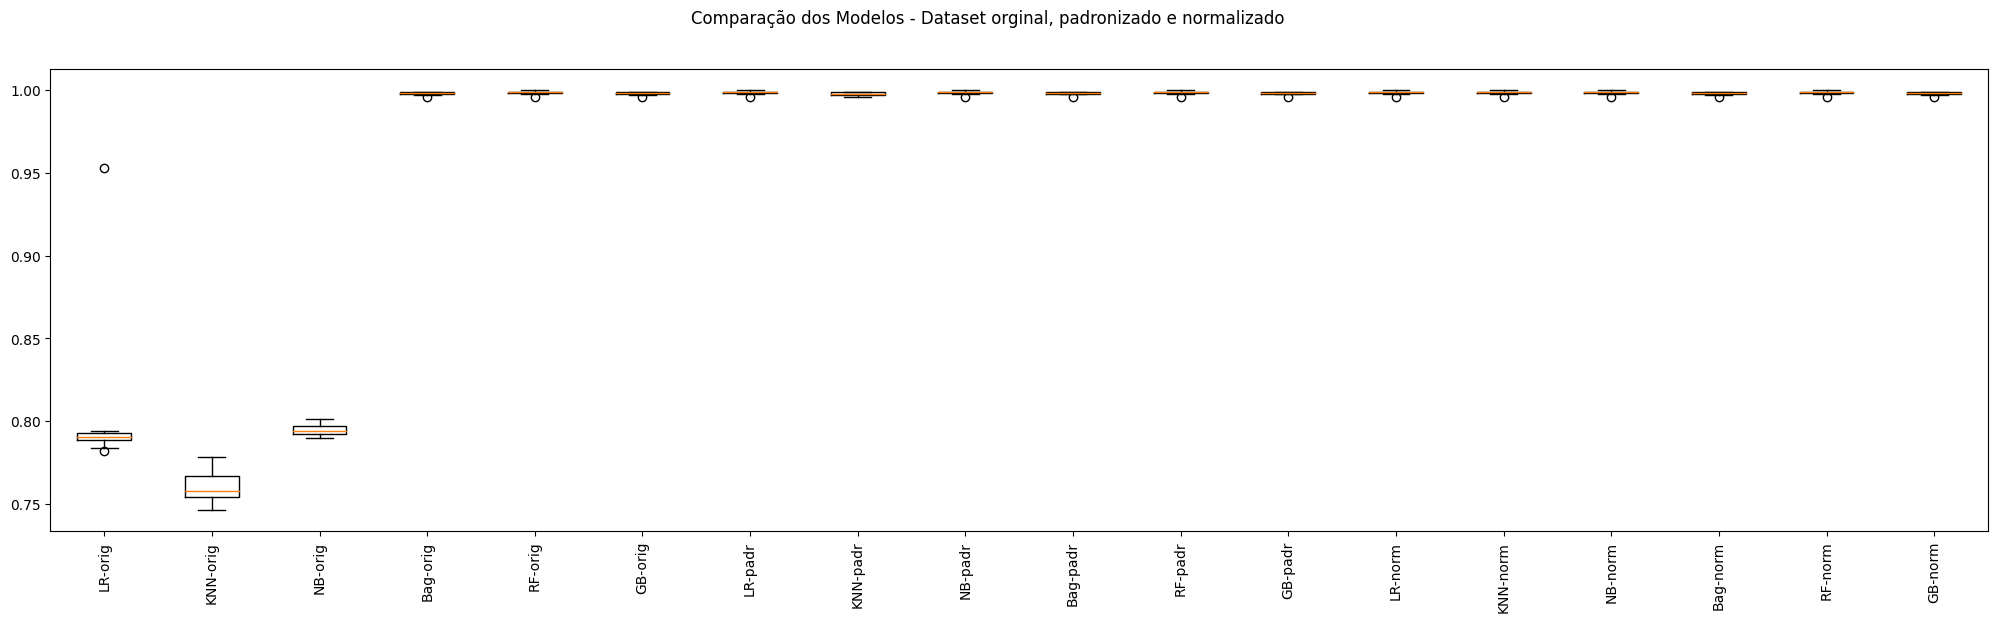

In [ ]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
naive_bayes = ('NB', GaussianNB())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))


# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))

# Executando os pipelines
aux = 1
for name, model in pipelines:
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)
    print('--------------------------------------------------------------')
    if aux == 6 or aux == 12 or aux == 18:
        print('#############################################################')
    aux = aux + 1

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()


- Na etapa acima foram testados 3 conjuntos com os mesmos modelos utilizados. Primeiro com os dados originais, em seguida com os dados padronizados e por último com os dados normalizados.
- Podemos perceber que apenas alguns modelos com os dados originais tiveram uma performance menor, com uma acurácia mínima de 0,75, os demais modelos dos 3 conjuntos de dados, performaram muito bem, com uma acurácia em torno de 0,99.
- Os 3 modelos que tiveram a pior performance foram: KNN-orig, NB-orig, LR-orig.

### Finalização do Modelo

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X) # aplicação da padronização no conjunto de treino
model = LogisticRegression(max_iter=200)
model.fit(rescaledX, y)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y, predictions))

0.9986


In [ ]:
# Salvando o modelo no disco
dump(model, open('lr_padronizado.pkl', 'wb'))

- No conjunto de teste, utilizei apenas a regreção logística com os dados padronizados e o modelo continuou performando muito bem com o conjunto de dados desconhecidos.
-  levando em consideração que os modelos já estão performando muito bem, não vejo necessidade de fazer mais otimizações nesse momento.

# MVP Sprint 2 - Parte 2: - Deep Learning - NLP: Tripadvisor Reviews 2023.
Comentários de hotéis extraídos do Tripadvisor

Conjunto de dados: Kaggle


## Sobre o conjunto de dados
Os hotéis desempenham um papel crucial nas viagens e, com o aumento do acesso à informação, surgiram novos caminhos para selecionar os melhores.
Com esse conjunto de dados, composto por 20 mil avaliações rastreadas do Tripadvisor, podemos explorar o que faz um ótimo hotel e talvez até usar esse modelo em suas viagens!

Essa base possue apenas duas colunas:

- review_full - Comentários/ avaliação fornecidos pelos usuários.
- rating_review - Classificação/avaliação fornecidas pelos usuários em uma escala de 1 a 5.

In [ ]:
# Bibliotecas adicionais de NLP
import re
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Bibliotecas para treinamento e cálculo de métricas
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
#from sklearn.metrics import plot_roc_curve
#from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.utils import resample

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Uso do core 'en_core_web_sm' do Spacy
nlp = spacy.load("en_core_web_sm")

# Download das stopworks do NLTK
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Análise da base

In [ ]:
#Leitura do datasets
df_reviews = pd.read_csv('https://github.com/karinesf/MVP2_POS_PUC_RIO/blob/master/Tripadvisor%20_Reviews%20_2023.csv?raw=true')

In [ ]:
# Verificando as 10 primeiras linhas
df_reviews.head(10)

,rating_review,review_full
0,5,"Totally in love with the Auro of the place, re..."
1,5,I went this bar 8 days regularly with my husba...
2,5,We were few friends and was a birthday celebra...
3,5,Fatjar Cafe and Market is the perfect place fo...
4,5,"Hey Guys, if you are craving for pizza and sea..."
5,5,We were looking for a special meal and we foun...
6,5,Kailash colony is brimming with small cafes no...
7,5,If you are looking for a varied selection of d...
8,5,Kailash Colony is the place I always head to w...
9,5,Real nice and comfortable bar. I am a whiskey ...


In [ ]:
# Verificando os tipos das colunas presentes no dataset
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147581 entries, 0 to 147580
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   rating_review  147581 non-null  int64 
 1   review_full    147579 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
#Fazendo uma cópia do dataset
df_alterado = df_reviews.copy()

In [ ]:
# Transformando a variábvel "review_full" para categórica
df_alterado.review_full = df_alterado.review_full.astype('category')

In [ ]:
# Verificando após transformação
df_alterado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147581 entries, 0 to 147580
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   rating_review  147581 non-null  int64   
 1   review_full    147579 non-null  category
dtypes: category(1), int64(1)
memory usage: 6.8 MB


In [ ]:
# Verificando quantidade de linhas e colunas
df_alterado.shape

(147581, 2)

In [ ]:
# Verificando valores nulos presente no dataset
df_alterado.isnull().sum()

rating_review    0
review_full      2
dtype: int64

In [ ]:
# Retirando os valores nulos encontrados
df_alterado = df_alterado.dropna()

In [ ]:
# Verificando dados duplicados
df_alterado.duplicated().sum()

137

In [ ]:
# Retirando valores duplicados encontrados
df_alterado = df_alterado.drop_duplicates()

In [ ]:
# Distribuição da variável de interesse
df_alterado[['rating_review']].value_counts(sort = False)

rating_review
1                 4449
2                 4549
3                15924
4                50204
5                72316
dtype: int64


- Observando a distribuição da variável 'rating_review' onde os usuários classificam os hotéis em uma escala de 1 a 5. Percebemos um desbalanciamento entre as classes. Existe uma grande quantidade de avaliações positivas (4 e 5) e pouca quantidade de avaliações negativas (1, 2, 3).
- Nesse caso, irei transformar a forma de análise das categorias, trasnformando-as em 3 tipos. Irei considerar as categorias 1 e 2 como 'Negativo', 3 como 'Neutro' e 4 e 5 como 'Positivo'.

In [ ]:
# Funnção para atender ao requisito acima
def MudarValor(x):
    if x == 1:
        x = 'Negativo'
    if x == 2:
        x = 'Negativo'
    if x == 3:
        x = 'neutro'
    if x == 4:
        x = 'Positivo'
    if x == 5:
        x = 'Positivo'
    return x

df_alterado['rating_review'] = df_alterado['rating_review'].apply(lambda x: MudarValor(x))

In [ ]:
# Verificando após transformação
df_alterado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147442 entries, 0 to 147580
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   rating_review  147442 non-null  object  
 1   review_full    147442 non-null  category
dtypes: category(1), object(1)
memory usage: 8.0+ MB


In [ ]:
# Transformando a variábvel "review_full" para categórica
df_alterado.rating_review = df_alterado.rating_review.astype('category')

In [ ]:
# Verificando após transformação
df_alterado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 147442 entries, 0 to 147580
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   rating_review  147442 non-null  category
 1   review_full    147442 non-null  category
dtypes: category(2)
memory usage: 7.0 MB


In [ ]:
# Distribuição da variável de interesse
df_alterado[['rating_review']].value_counts(sort = False)

rating_review
Negativo           8998
Positivo         122520
neutro            15924
dtype: int64

- Dessa forma, agora temos apenas 3 categorias dentro da variável e assim espero melhorar também a performance dos modelos com essa transformação.

### Pré tratamento dos dados

In [ ]:
# Carregamento das stopwords em inglês
stopwords = nltk.corpus.stopwords.words('english')

In [ ]:
# Função de tratamento
def tratamento_review(texto):

    texto = re.sub("[0-9]+","", texto) # Exclusão de dígitos
    texto = texto.lower() # Caixa baixa
    texto = re.sub(r"[^\w\s]", "",texto) # Exclusão de caracteres especiais

    texto = re.sub(' +', ' ', texto) # Exclusão de espaçamentos repetitivos entre as frases

    doc= nlp(texto) # Tokenização

    tokens=[token.text for token in doc if token.text not in stopwords] # Filtragem adicional com os caracteres em stopwords

    return " ".join(tokens)

In [ ]:
# Aplicando a função acima na coluna review _full
df_alterado['review_full'] = df_alterado['review_full'].apply(lambda x: tratamento_review(x))

In [ ]:
# Verificando estrutura do texto da coluna review_full depois da limpeza
df_alterado.review_full[0]

'totally love auro place really beautiful quite fancy time ambience pure gives sense positivity throughout outdoor indoor interior quite quaint cute love open kitchen idea whole marketplace ideology due coronovirus specifically use disposable cutlery keep pandemic mind taking precautionary measures beginning place mask staff using good sanitisation food really amazing specially pizza straight oven hummus pita bread quite delicious looking classy yet soothing italian place delhifatjar go'

## Modelagem
Nesta etapa serão gerados alguns Pipelines com a utilização de 3 modelos:

- Regressão logística - é uma técnica estatística que tem como objetivo produzir, a partir de um conjunto de observações, um modelo que permita a predição de valores tomados por uma variável categórica, frequentemente binária, a partir de uma série de variáveis explicativas contínuas e/ou binárias.

- Naive Bayes Classifier - realiza uma classificação probabilística de observações, tomando como premissa a suposição de independência entre as variáveis do problema.

- Random Forest Classifier - Florestas aleatórias ou florestas de decisão aleatória é um método de aprendizado conjunto para classificação, regressão e outras tarefas que opera construindo uma infinidade de árvores de decisão em tempo de treinamento.

Cada modelo será testado com duas técnicas de vetorização:

- CountVectorizer - Ele é usado para transformar um determinado texto em um vetor com base na frequência (contagem) de cada palavra que ocorre em todo o texto.

- TfidfVectorizer - Pode ser definido como o cálculo da relevância de uma palavra em uma série ou corpus para um texto. O significado aumenta proporcionalmente ao número de vezes que uma palavra aparece no texto, mas é compensado pela frequência da palavra no corpus (conjunto de dados).

O objetivo nessa etapa é conseguir gerar um modelo que consiga classificar bem os dados.

In [ ]:
#Train Test Split
from sklearn.model_selection import train_test_split

X = df_alterado['review_full']
y = df_alterado['rating_review']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Criando um Pipeline com CountVectorizer e LogisticRegression

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

count_lg = Pipeline([('count_vect', CountVectorizer(analyzer='word', stop_words=stopwords)),
                     ('lg', LogisticRegression()),
])

# Feed the training data through the pipeline
count_lg.fit(X_train, y_train)

Pipeline(steps=[('count_vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('lg', LogisticRegression())])

In [ ]:
predictions = count_lg.predict(X_test)

In [ ]:
# Classification Report
from sklearn import metrics

print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

    Negativo       0.69      0.60      0.64      2689
    Positivo       0.92      0.97      0.94     36700
      neutro       0.52      0.35      0.42      4844

    accuracy                           0.88     44233
   macro avg       0.71      0.64      0.67     44233
weighted avg       0.86      0.88      0.87     44233



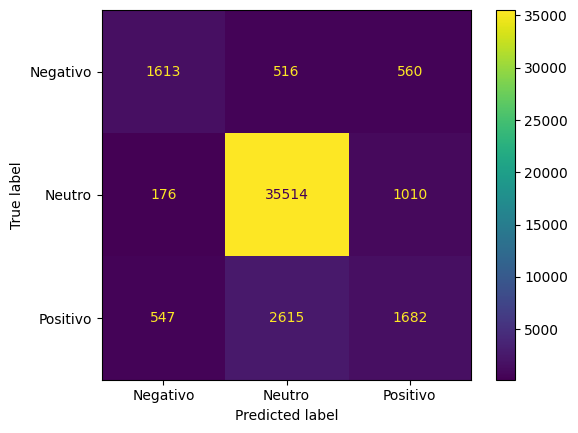

In [ ]:
# Visualizando a Matriz de Confusão do Modelo
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Negativo', 'Neutro', 'Positivo'])
_ = disp.plot(values_format='d')

### Criando um Pipeline com TfidfVectorizer e LogisticRegression

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
tfidf_lg = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', stop_words=stopwords)),
                     ('lg', LogisticRegression()),
])

# Feed the training data through the pipeline
tfidf_lg.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('lg', LogisticRegression())])

In [ ]:
predictions = tfidf_lg.predict(X_test)

In [ ]:
# Classification Report
from sklearn import metrics

print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

    Negativo       0.75      0.59      0.66      2689
    Positivo       0.91      0.98      0.95     36700
      neutro       0.59      0.33      0.43      4844

    accuracy                           0.89     44233
   macro avg       0.75      0.63      0.68     44233
weighted avg       0.87      0.89      0.87     44233



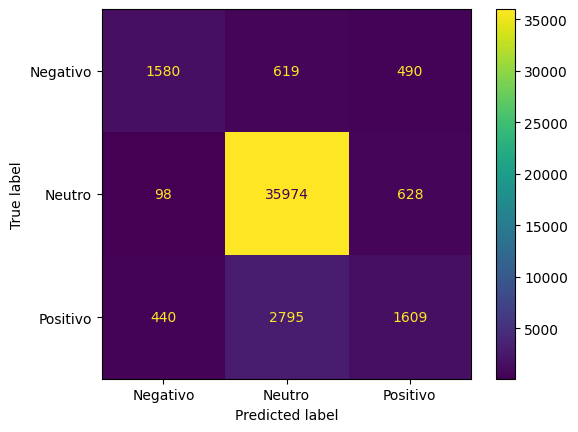

In [ ]:
# Visualizando a Matriz de Confusão do Modelo
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Negativo', 'Neutro', 'Positivo'])
_ = disp.plot(values_format='d')

### Criando um Pipeline com CountVectorizer e LinearSVC

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

count_svc = Pipeline([('count_vect', CountVectorizer(analyzer='word', stop_words=stopwords)),
                     ('svc', LinearSVC()),
])

# Feed the training data through the pipeline
count_svc.fit(X_train, y_train)

Pipeline(steps=[('count_vect',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('svc', LinearSVC())])

In [ ]:
predictions = count_svc.predict(X_test)

In [ ]:
# Classification Report
from sklearn import metrics

print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

    Negativo       0.66      0.57      0.61      2689
    Positivo       0.92      0.96      0.94     36700
      neutro       0.46      0.34      0.39      4844

    accuracy                           0.87     44233
   macro avg       0.68      0.62      0.65     44233
weighted avg       0.85      0.87      0.86     44233



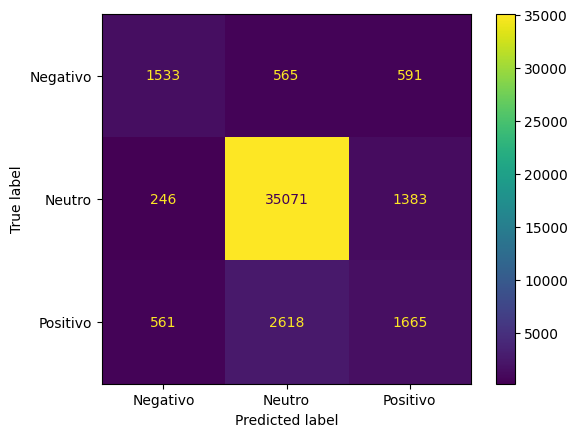

In [ ]:
# Visualizando a Matriz de Confusão do Modelo
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Negativo', 'Neutro', 'Positivo'])
_ = disp.plot(values_format='d')

### Criando um Pipeline com TfidfVectorizer e LinearSVC

In [ ]:
tfidf_svc = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', stop_words=stopwords)),
                     ('svc', LinearSVC()),
])

# Feed the training data through the pipeline
tfidf_svc.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('svc', LinearSVC())])

In [ ]:
predictions = tfidf_svc.predict(X_test)

In [ ]:
# Classification Report
from sklearn import metrics

print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

    Negativo       0.71      0.62      0.66      2689
    Positivo       0.92      0.98      0.95     36700
      neutro       0.57      0.31      0.41      4844

    accuracy                           0.88     44233
   macro avg       0.73      0.64      0.67     44233
weighted avg       0.86      0.88      0.87     44233



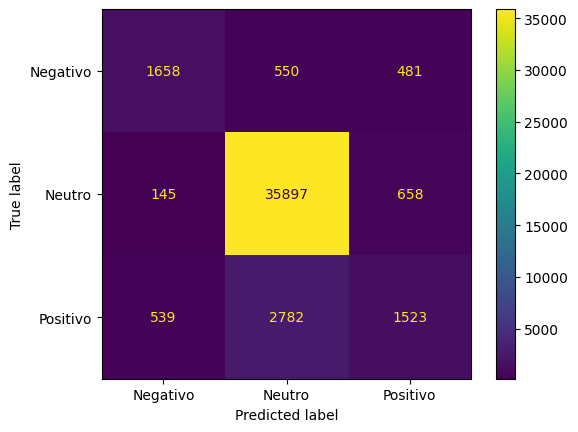

In [ ]:
# Visualizando a Matriz de Confusão do Modelo
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Negativo', 'Neutro', 'Positivo'])
_ = disp.plot(values_format='d')

### Criando um Pipeline com CountVectorizer e Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB

count_bayes = Pipeline([('count_vec', CountVectorizer(analyzer='word', stop_words=stopwords)),
                     ('naive_bayes', MultinomialNB()),
])

# Feed the training data through the pipeline
count_bayes.fit(X_train, y_train)

Pipeline(steps=[('count_vec',
                 CountVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('naive_bayes', MultinomialNB())])

In [ ]:
predictions = count_bayes.predict(X_test)

In [ ]:
# Classification Report
print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

    Negativo       0.73      0.54      0.62      2689
    Positivo       0.91      0.98      0.94     36700
      neutro       0.52      0.30      0.38      4844

    accuracy                           0.88     44233
   macro avg       0.72      0.61      0.65     44233
weighted avg       0.85      0.88      0.86     44233



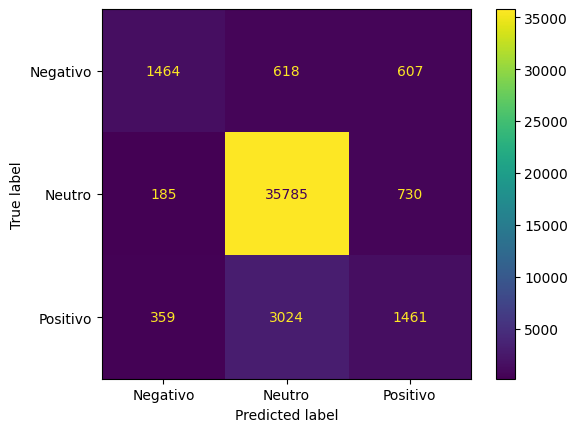

In [ ]:
# Visualizando a Matriz de Confusão do Modelo
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Negativo', 'Neutro', 'Positivo'])
_ = disp.plot(values_format='d')

### Criando um Pipeline com TfidfVectorizer e Naive Bayes Classifier

In [ ]:
tfidf_bayes = Pipeline([('tfidf', TfidfVectorizer(analyzer='word', stop_words=stopwords)),
                     ('naive_bayes', MultinomialNB()),
])

# Feed the training data through the pipeline
tfidf_bayes.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(stop_words=['i', 'me', 'my', 'myself', 'we',
                                             'our', 'ours', 'ourselves', 'you',
                                             "you're", "you've", "you'll",
                                             "you'd", 'your', 'yours',
                                             'yourself', 'yourselves', 'he',
                                             'him', 'his', 'himself', 'she',
                                             "she's", 'her', 'hers', 'herself',
                                             'it', "it's", 'its', 'itself', ...])),
                ('naive_bayes', MultinomialNB())])

In [ ]:
predictions = tfidf_bayes.predict(X_test)

In [ ]:
# Classification Report
from sklearn import metrics

print(metrics.classification_report(y_test,predictions))

              precision    recall  f1-score   support

    Negativo       1.00      0.00      0.01      2689
    Positivo       0.83      1.00      0.91     36700
      neutro       0.00      0.00      0.00      4844

    accuracy                           0.83     44233
   macro avg       0.61      0.33      0.30     44233
weighted avg       0.75      0.83      0.75     44233



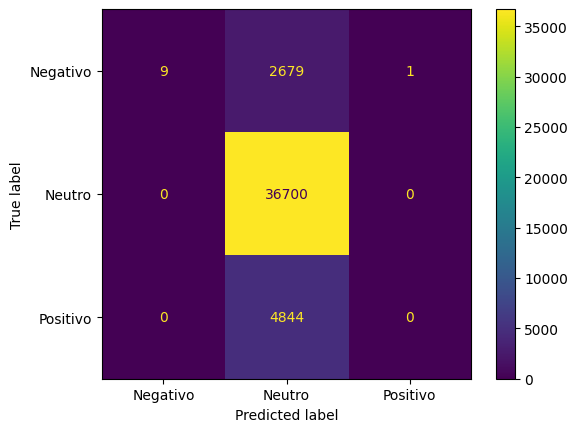

In [ ]:
# Visualizando a Matriz de Confusão do Modelo
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=['Negativo', 'Neutro', 'Positivo'])
_ = disp.plot(values_format='d')

### Comentários finais:
 - Dentre os pipelines testados, o que obteve as melhores métricas foi a Logistic Regression, tanto utilizando o CountVectorizer como o TfidfVectorizer, se mostrando melhor com o último.

   - A utilização da técnica de vetorização TfidfVectorizer melhorou seu desempenho;
   - Obteve maior número de acertos, diminuindo assim a quantidade de erros, com  isso conseguiu melhorar tanto o recall como o precission e assim melhorando as demais métricas de avaliação.
   
- Devido aos comentários acima, o modelo escolhido foi o Modelo 2 "Pipeline com Logistic Regression e TfidfVectorizer".

 - O pipeline com pior performance foi o NaiveBayes Classifier, tanto utilizandocom a utilização do Tfidfvectorizer, chegando a zerar o número de acertos em determinadas categorias.

 - Os demais modelos não tiveram uma diferença significante em relação ao tipo de vetorização utilizado.

- Próximos passos:
  - Mexer nos parâmetros do modelo escolhido para tentar melhorar a quantidade de acertos.